# COCO Dataset Compilation

This notebook shows how we compile the COCO dataset. Note that in this demostration, we import necessary paths from a file `localpaths.py` which contains the paths for all relevant directories. This is not released as part of the repo.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import time
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import kornia
import io
import numpy as np
import IPython.display as display
import sys

In [3]:
# Import litdata from parent
sys.path.append('../')
from litdata.writer import LITWriter
from litdata.litdata import LITDataset

In [4]:
from localpaths import (
    LITDATAPATH, COCO_CAPTIONS_PATH, COCO_IMAGE_PATH,
    COCO_KEYPOINT_PATH, COCO_PANOPTIC_PATH
)

In [5]:
# Load all COCO annotations. NOTE: Panoptic labels include both things and stuff

with open(os.path.join(COCO_PANOPTIC_PATH, 'panoptic_train2017.json'), 'r') as infile:
    annpo_train = json.load(infile)
    
with open(os.path.join(COCO_PANOPTIC_PATH, 'panoptic_val2017.json'), 'r') as infile:
    annpo_val = json.load(infile)

with open(os.path.join(COCO_KEYPOINT_PATH, 'person_keypoints_train2017.json'), 'r') as infile:
    annkp_train = json.load(infile)
    
with open(os.path.join(COCO_KEYPOINT_PATH, 'person_keypoints_val2017.json'), 'r') as infile:
    annkp_val = json.load(infile)
    
with open(os.path.join(COCO_CAPTIONS_PATH, 'captions_train2017.json'), 'r') as infile:
    anncap_train = json.load(infile)

with open(os.path.join(COCO_CAPTIONS_PATH, 'captions_val2017.json'), 'r') as infile:
    anncap_val = json.load(infile)


In [6]:
# Merge all images into single dictionaries

image_list = annkp_train['images'] + anncap_train['images'] + annpo_train['images']
image_dict_train = {}
for i in image_list:
    image_dict_train[i['id']] = i
    
image_list = annkp_val['images'] + anncap_val['images'] + annpo_val['images']
image_dict_val = {}
for i in image_list:
    image_dict_val[i['id']] = i

del image_list

In [7]:
def get_inv_anndict(annotation):
    anndict = {}
    for a in annotation['annotations']:
        imid = a['image_id']
        if imid not in anndict:
            anndict[imid] = []
        anndict[imid] += [a]
    return anndict

In [8]:
annpo_train_dct = get_inv_anndict(annpo_train)
annkp_train_dct = get_inv_anndict(annkp_train)
anncap_train_dct = get_inv_anndict(anncap_train)

annpo_val_dct = get_inv_anndict(annpo_val)
annkp_val_dct = get_inv_anndict(annkp_val)
anncap_val_dct = get_inv_anndict(anncap_val)

In [9]:
from typing import Tuple, List, Union

def _get_nonconvex_edges(polygons: torch.Tensor, h: int, w: int) -> torch.Tensor:
    B, N, _ = polygons.shape
    ws = torch.arange(w, device=polygons.device, dtype=polygons.dtype)[None, None, None, :]
    hs = torch.arange(h, device=polygons.device, dtype=polygons.dtype)[None, None, :, None]
    polygons = polygons[..., None, None, :]  # B, N, 1, 1, 2 for broadcasting
    p1 = polygons[:, :-1]  # B, N-1, 1, 1, 2
    p2 = polygons[:, 1:]  # B, N-1, 1, 1, 2
    min_p = torch.min(p1, p2)
    max_p = torch.max(p1, p2)
    p_horizontal = (min_p[..., 1] < hs) & (hs <= max_p[..., 1])
    p_intersect = (hs - p1[..., 1]) * (p2[..., 0] - p1[..., 0]) / (p2[..., 1] - p1[..., 1] + 1e-6) + p1[..., 0]
    p_intersect = torch.where(p_horizontal, p_intersect, float('inf'))
    intersections = torch.sum(p_intersect < ws, dim=1)
    mask = intersections % 2 == 1
    return mask

def draw_nonconvex_polygon(images: torch.Tensor, polygons: torch.Tensor, colors: torch.Tensor) -> torch.Tensor:
    b_i, c_i, h_i, w_i, device = *images.shape, images.device
    b_p, _, xy, device_p, dtype_p = *polygons.shape, polygons.device, polygons.dtype
    if len(colors.shape) == 1:
        colors = colors.expand(b_i, c_i)
    b_c, _, device_c = *colors.shape, colors.device
    fill_region = _get_nonconvex_edges(polygons, h_i, w_i)
    images = (~fill_region[:, None]) * images + fill_region[:, None] * colors[..., None, None]
    return images

def polygon2rle(sample, idx, train=True):
    if train:
        kpdict = annkp_train_dct
        imdict = image_dict_train
    else:
        kpdict = annkp_val_dct
        imdict = image_dict_val
        
    if sample not in imdict:
        return None
    if sample not in kpdict:
        return None
    
    kpsample = kpdict[sample]
    imsample = imdict[sample]
    
    h, w = imsample['height'], imsample['width']
    outimg = torch.zeros(1, 1, h, w)
    
    polyobj = kpsample[idx]['segmentation']
    assert isinstance(polyobj, list)
    for i in range(len(polyobj)):
        polygons = torch.tensor(polyobj[i]).view(1, -1, 2)
        polygons = F.pad(polygons[None,...], (0,0,0,1), mode='circular')[0]
        outimg = draw_nonconvex_polygon(
            outimg, polygons, torch.full((1,1), 1)
        )
    return outimg[0,0].numpy().astype(np.uint8)
    

In [10]:
def _cvbb(bbox):
    xmin, ymin, width, height = bbox
    xmax = xmin + width
    ymax = ymin + height
    return [xmin, ymin, xmax, ymax]

def get_keypoints(sample, train=True):
    
    if train:
        dictionary = annkp_train_dct
    else:
        dictionary = annkp_val_dct
    
    if sample not in dictionary:
        return None
    keypoint_objects = dictionary[sample]
    kp_out = []
    seg_out = []
    bb_out = []
    bbkeys = ['class', 'xmin', 'ymin', 'xmax', 'ymax']

    for i, kp in enumerate(keypoint_objects):
        keypoints = np.array(kp['keypoints']).reshape(17, 3)
        segmentation = kp['segmentation']
        bbox = {k:v for k,v in zip(bbkeys, [kp['category_id']] + _cvbb(kp['bbox']))}
        if isinstance(segmentation, list):
            # Case: Polygon
            seg_out += [polygon2rle(sample, i, train)]
            
        elif isinstance(segmentation, dict):
            # Case RLE
            size = tuple(reversed(segmentation['size']))
            cnt = np.array(segmentation['counts'])
            vals = np.ones_like(cnt, dtype=np.bool_)
            vals[::2] = 0
            seg_out += [np.repeat(vals, cnt).reshape(*size).transpose(1,0)]
            
        kp_out.append(keypoints)
        bb_out.append(bbox)
    
    return np.stack(kp_out, 0), np.stack(seg_out, 0), bb_out

In [11]:
def get_panoptic(sample, train=True):
    fold = 'train' if train else 'val'
    infolder = os.path.join(COCO_PANOPTIC_PATH, f'panoptic_{fold}2017/')
    cur_img_dict = image_dict_train if train else image_dict_val
    cur_ann_dict = annpo_train_dct if train else annpo_val_dct
    
    fname = cur_ann_dict[sample][0]['file_name']
    fpath = os.path.join(infolder, fname)    
    
    assert sample in cur_img_dict
    if sample not in cur_ann_dict:
        return None
    
    pixels = np.array(Image.open(fpath), dtype=np.uint32)
            
    assert len(cur_ann_dict[sample]) == 1
    segments_info = cur_ann_dict[sample][0]['segments_info']
    cat_map = {0:0, **{s['id']:s['category_id'] for s in segments_info}}
    
    # Get instance ids and lookup non_occuring values
    instance_ids = pixels[..., 0] + pixels[..., 1] * 256 + pixels[..., 2] * 256 * 256
    instance_unique, instance_inv = np.unique(instance_ids, return_inverse=True)
    instance_inv = instance_inv.reshape(*instance_ids.shape)
    
    cat_unique = np.vectorize(cat_map.get)(instance_unique)
    cat_ids = cat_unique[instance_inv]
    
    # Get bounding boxes
    bbkeys = ['class', 'xmin', 'ymin', 'xmax', 'ymax']
    bbox_dict = {s['id']:{k:v for k,v in zip(bbkeys, [s['category_id']] + _cvbb(s['bbox']))} for s in segments_info}
    bboxes = [bbox_dict[u] for u in instance_unique if u != 0]
    
    return cat_ids.astype(np.uint8), instance_inv.astype(np.uint8), instance_unique, bboxes
            

In [12]:
licences = {l['id']:l['url'] for l in annpo_train['licenses']}

def get_img_metadata(sample, train=True):
    cur_img_dict = image_dict_train if train else image_dict_val
    assert sample in cur_img_dict
    cur_img = cur_img_dict[sample]
    captime = time.strptime(cur_img['date_captured'], '%Y-%m-%d %H:%M:%S')
    return {
        'timestamp': int(time.mktime(captime)),
        'license': licences[cur_img['license']],
        'flickr': cur_img['flickr_url'],
        'coco': cur_img['coco_url'],
    }

def get_caption(sample, train=True):
    fold = 'train' if train else 'val'
    cur_img_dict = image_dict_train if train else image_dict_val
    cur_ann_dict = anncap_train_dct if train else anncap_val_dct

    assert sample in cur_img_dict
    if sample not in cur_ann_dict:
        return None
    
    return [s['caption'] for s in cur_ann_dict[sample]]

In [13]:
def format_semantics(thing):
    if thing['isthing']:
        mcat = 'thing'
    else:
        mcat = 'stuff'
    scat = thing['supercategory']
    cat = thing['name']
    return f'{mcat}/{scat}/{cat}'

labeldict = {0: 'background/void/-', **{c['id']:format_semantics(c) for c in annpo_train['categories']}}

In [14]:
additional_metadata = {
    'website': 'https://cocodataset.org/#home',
    'used_semantic_classes': len(labeldict),
    'num_semantic_classes': max(labeldict.keys()),
    'num_semantic_thing_classes': len([l for l in labeldict.values() if l.startswith('thing')]),
    'num_semantic_stuff_classes': len([l for l in labeldict.values() if l.startswith('stuff')]),
    'num_supercategories': len(set([l.split('/')[1] for l in labeldict.values()])),
    'num_supercategories_wo_background': len(set([l.split('/')[1] for l in labeldict.values()]))-1,
}

In [15]:
def get_objdict(sample, train=True):
    fold = 'train' if train else 'val'
    cur_img_dict = image_dict_train if train else image_dict_val
    imgloc = os.path.join(COCO_IMAGE_PATH, f'{fold}2017/')
    fname = cur_img_dict[sample]['file_name']
    imgpath = os.path.join(imgloc, fname)
    assert os.path.isfile(imgpath)
    
    keyname, ext = os.path.splitext(fname)
    imgmeta = get_img_metadata(sample, train)
    objdict = {'__key__': keyname, 'jpg': Image.open(imgpath), 'metadata.json': imgmeta}
    
    segdata = get_panoptic(sample, train)
    if segdata is not None:
        seg, ins, insmap, bb = segdata
        objdict['semantic.seg8'] = seg
        objdict['instance.seg8'] = ins
        objdict['cocoinstancemap.npy'] = insmap
        objdict['bbox.json'] = bb
    
    capdata = get_caption(sample, train)
    if capdata is not None:
        objdict['captions.json'] = capdata
    
    kpdata = get_keypoints(sample, train)
    if kpdata is not None:
        kpoint, kpseg, kpbb = kpdata
        objdict['keypoints.rle'] = kpoint
        objdict['keypoints.segmentation.rle'] = kpseg
        objdict['keypoints.bbox.json'] = kpbb
            
    return objdict

In [16]:
with LITWriter(
    'COCO', 
    LITDATAPATH, 
    additional_metadata=additional_metadata,
    groupname = 'DSB@UiO',
    shard_maxsize = 1e9
) as litwriter:
    for i, key in enumerate(image_dict_train):
        objdict = get_objdict(key, train=True)
        litwriter.train.write(objdict)
        if i % 250 == 0:
            display.clear_output(wait=True)
            print(f'train: {i:12d}/{len(image_dict_train):12d}')
            print(litwriter.train)
                    
    for i, key in enumerate(image_dict_val):
        objdict = get_objdict(key, train=False)
        litwriter.val.write(objdict)
        if i % 250 == 0:
            display.clear_output(wait=True)
            print(f'train: {i:12d}/{len(image_dict_val):12d}')
            print(litwriter.val)

train:         4750/        5000
ShardWriter(
	Current Shard: /work2/litdata/COCO/val_0000.tar
	Current Shard Size: 0.33 GB
	Current Shard File Count: 4751
	Total File Count: 4751
)


In [17]:
dataset = LITDataset('COCO', LITDATAPATH, True)

In [18]:
img, seg, ins, insmap, bbox, cap, kp, kpseg, kpbb, md = dataset[0]

['a man is flying a kite in a field', 'A man is flying a kite outside in a field', 'A person flying a kite in the grass, during the day.', 'A man that is standing in the grass with a kite.', 'A person flying a kite in a field.']
{'timestamp': 1384451440, 'license': 'http://creativecommons.org/licenses/by-nc-nd/2.0/', 'flickr': 'http://farm5.staticflickr.com/4135/4921664146_f876699bf2_z.jpg', 'coco': 'http://images.cocodataset.org/train2017/000000275015.jpg'}


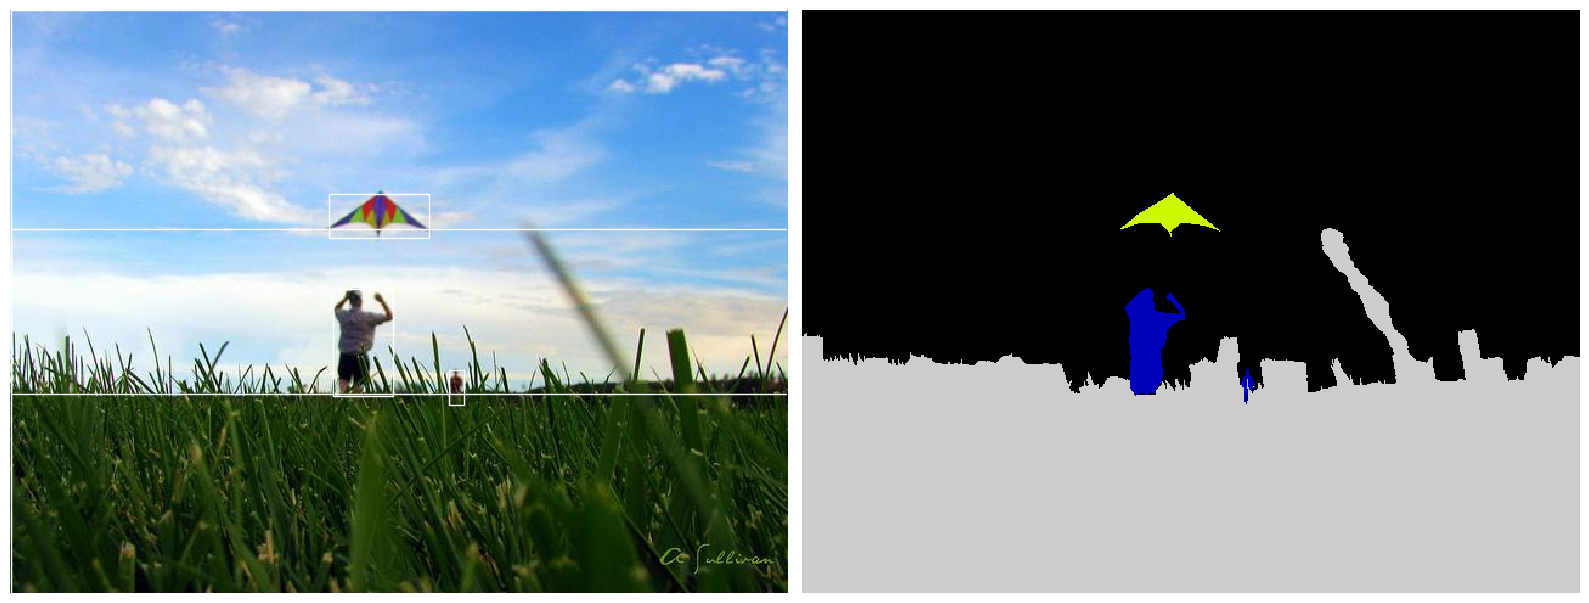

In [19]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].matshow(np.array(img))
ax[1].matshow(seg % 17, cmap='nipy_spectral')
for bb in bbox:
    rect = patches.Rectangle(
        (bb['xmin'], bb['ymin']), 
        bb['xmax'] - bb['xmin'], 
        bb['ymax'] - bb['ymin'], 
        linewidth=1, 
        edgecolor='w', 
        facecolor='none'
    )
    ax[0].add_patch(rect)

for a in ax:
    a.axis('off')
    
plt.tight_layout()
    
print(cap)
print(md)

In [20]:
dataset

LITDataset(
    	fold=train,
	length=64115,
	use_extensions=('.jpg', '.semantic.seg8', '.instance.seg8', '.cocoinstancemap.npy', '.bbox.json', '.captions.json', '.keypoints.rle', '.keypoints.segmentation.rle', '.keypoints.bbox.json', '.metadata.json'),
	website = https://cocodataset.org/#home,
	used_semantic_classes = 134,
	num_semantic_classes = 200,
	num_semantic_thing_classes = 80,
	num_semantic_stuff_classes = 53,
	num_supercategories = 28,
	num_supercategories_wo_background = 27,
	num_train = 118287,
	num_val = 5000,
)

In [21]:
with open(os.path.join(LITDATAPATH, 'COCO/labeldict.json'), 'w') as outfile:
    json.dump(labeldict, outfile)